<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Quantum_Trajectory_Simulation_of_Tb_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
[INFO] Using Ni₄W‑derived SOT amplitude  B_sot = 5.5948e-03 T


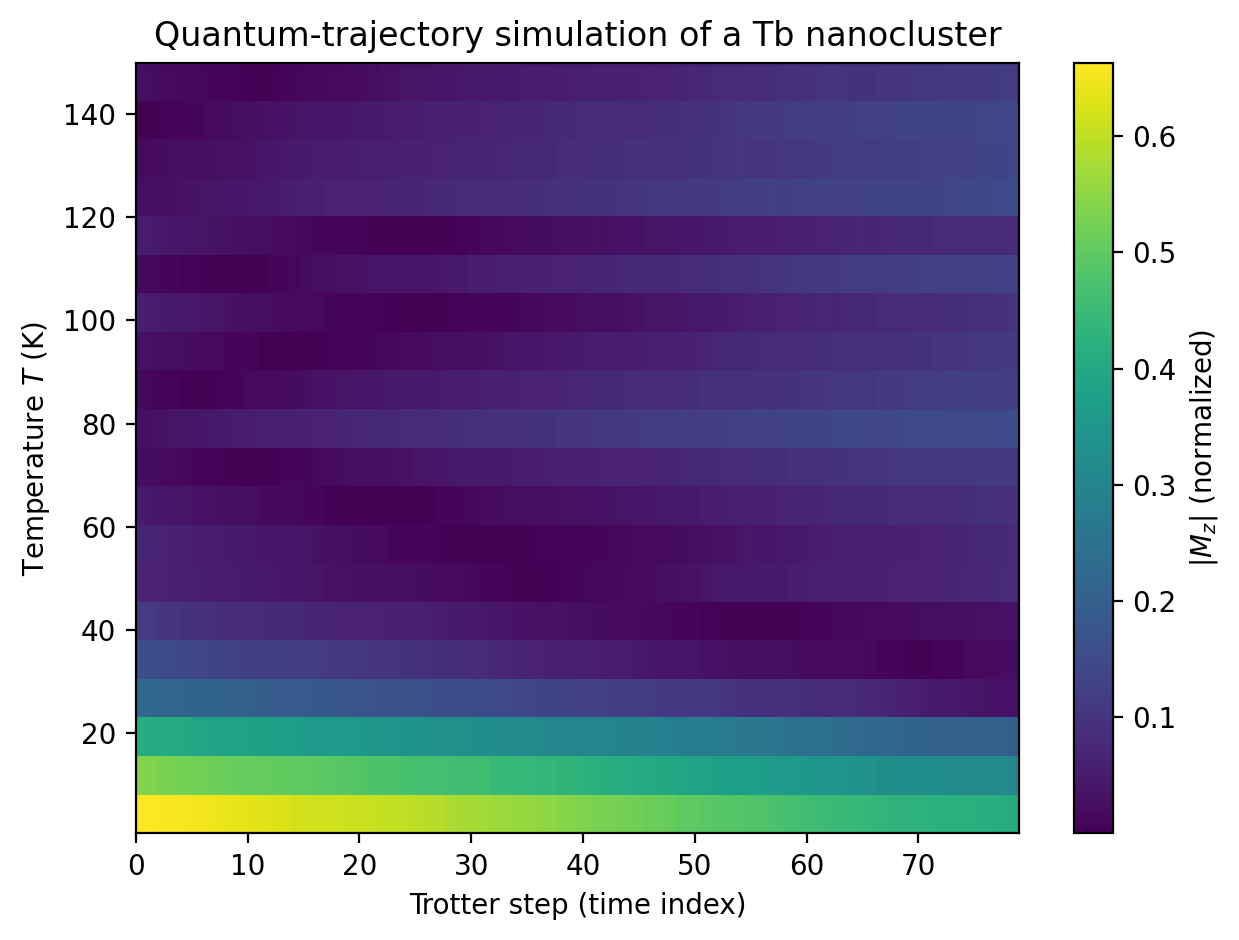

In [2]:
# -*- coding: utf-8 -*-
"""
tb_trajectory_qmc.py

Monte‑Carlo quantum‑trajectory (quantum‑jump) simulation of a tiny Tb
nanocluster: Heisenberg exchange + uniaxial anisotropy + optional
spin‑orbit‑torque (SOT) drive.  The stochastic unraveling provides a
quantum‑native analogue of Landau‑Lifshitz‑Gilbert damping.

Author: Onri Jay Benally (2025)
License: CC‑BY‑4.0
"""

# -------------------------------------------------------------------------
# SECTION 0 – GPU / Qiskit installation
# -------------------------------------------------------------------------
# The original notebook tried to install a non‑existent Qiskit 2.2 release.
# Use a recent (and actively maintained) Qiskit version instead.
# In a Colab/Notebook you can run the two lines below in a separate cell.
# -------------------------------------------------
!nvcc --version                # check your CUDA version (optional)
!pip install -q "qiskit>=0.45" "qiskit-aer-gpu-cu11==0.17.2" pylatexenc
# -------------------------------------------------


# -------------------------------------------------------------------------
# IMPORTS
# -------------------------------------------------------------------------
from __future__ import annotations

import math
from dataclasses import dataclass, field
from typing import List, Tuple

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Qiskit is used only for its convenient Pauli class.
try:
    from qiskit.quantum_info import Pauli
except Exception as exc:                     # pragma: no cover
    raise ImportError(
        "Qiskit is required for this notebook.  "
        "Run `!pip install qiskit` in a separate cell and restart the runtime."
    ) from exc

# Physical constants that we need for the SOT field estimate
from scipy.constants import hbar, elementary_charge, mu_0

# -------------------------------------------------------------------------
# HIGH‑LEVEL CONTROL PARAMETERS
# -------------------------------------------------------------------------
@dataclass
class Knobs:
    """High‑level control parameters for the trajectory simulation."""
    # -----------------------------------------------------------------
    # 0 – Geometry
    # -----------------------------------------------------------------
    size_nm: float                     # particle diameter (nm)

    # -----------------------------------------------------------------
    # 1 – Model parameters (arbitrary energy units)
    # -----------------------------------------------------------------
    J_EX: float = 1.0                  # Heisenberg exchange strength
    D_ANISO: float = 0.2               # Uniaxial anisotropy strength

    # -----------------------------------------------------------------
    # 2 – Spin‑orbit‑torque (SOT) drive
    # -----------------------------------------------------------------
    sot_amplitude: float = 0.0         # effective transverse field (energy units)
    sot_pulse_steps: int = 0           # number of Trotter steps the pulse is active

    # -----------------------------------------------------------------
    # 3 – Dissipation (LLG‑like) rates
    # -----------------------------------------------------------------
    gamma_relax: float = 0.02          # amplitude‑damping (σ⁻ channel)
    gamma_deph: float = 0.01           # pure dephasing (σ_z channel)

    # -----------------------------------------------------------------
    # 4 – Monte‑Carlo settings
    # -----------------------------------------------------------------
    trotter_steps: int = 60            # time slices per simulation
    dt: float = 0.1                    # time step size (arbitrary units)
    n_trajectories: int = 500          # number of stochastic runs to average
    seed: int = 12345                  # RNG seed

    # -----------------------------------------------------------------
    # 5 – Temperature sweep (optional)
    # -----------------------------------------------------------------
    # The original code passed a ``temps_K`` keyword argument, but the
    # dataclass did not declare the field.  Adding it (with a mutable‑safe
    # default_factory) fixes the ``TypeError`` you saw.
    temps_K: np.ndarray = field(default_factory=lambda: np.array([]))


# -------------------------------------------------------------------------
# CLUSTER TOPOLOGY (same mapping as the original code)
# -------------------------------------------------------------------------
def size_to_cluster_config(size_nm: float) -> Tuple[int, List[Tuple[int, int]]]:
    """Return (n_spins, edge list) for the requested particle size."""
    # Dimer
    if size_nm < 0.5:
        return 2, [(0, 1)]
    # Plaquette (2×2)
    if size_nm < 0.8:
        return 4, [(0, 1), (1, 2), (2, 3), (3, 0)]
    # 6‑spin open chain
    if size_nm < 2.0:
        n = 6
        edges = [(i, i + 1) for i in range(n - 1)]
        return n, edges
    # 8‑spin open chain
    if size_nm < 5.0:
        n = 8
        edges = [(i, i + 1) for i in range(n - 1)]
        return n, edges
    # 12‑spin open chain (max for dense‑matrix simulation)
    n = 12
    edges = [(i, i + 1) for i in range(n - 1)]
    return n, edges


# -------------------------------------------------------------------------
# PAULI MATRICES ON A MULTI‑QUBIT REGISTER
# -------------------------------------------------------------------------
def pauli_on_register(num_qubits: int, target: int, pauli_label: str) -> np.ndarray:
    """
    Return a matrix representing a single‑qubit Pauli operator acting on
    ``target`` (0‑indexed from the left) in a ``num_qubits``‑qubit Hilbert
    space.  The result has shape (2**num_qubits, 2**num_qubits).
    """
    op = Pauli(pauli_label).to_matrix()
    # Build the full tensor product using kron; the leftmost qubit is index 0.
    result = 1
    for i in range(num_qubits):
        result = np.kron(op if i == target else np.eye(2), result)
    return result


def build_many_body_operator(num_qubits: int,
                            sites: Tuple[int, int],
                            label: str) -> np.ndarray:
    """
    Return a two‑body operator for a pair of sites.  ``label`` must be
    one of 'XX', 'YY' or 'ZZ'.
    """
    if label == "XX":
        op1 = pauli_on_register(num_qubits, sites[0], "X")
        op2 = pauli_on_register(num_qubits, sites[1], "X")
    elif label == "YY":
        op1 = pauli_on_register(num_qubits, sites[0], "Y")
        op2 = pauli_on_register(num_qubits, sites[1], "Y")
    elif label == "ZZ":
        op1 = pauli_on_register(num_qubits, sites[0], "Z")
        op2 = pauli_on_register(num_qubits, sites[1], "Z")
    else:
        raise ValueError(f"Unsupported label {label}")
    return op1 @ op2


# -------------------------------------------------------------------------
# HAMILTONIAN CONSTRUCTION
# -------------------------------------------------------------------------
def build_hamiltonian(n_spins: int,
                     edges: List[Tuple[int, int]],
                     J_ex: float,
                     D_aniso: float,
                     B_sot: float = 0.0) -> np.ndarray:
    """
    Heisenberg exchange + uniaxial anisotropy + optional SOT field.
    Returns a dense matrix of shape (2**n_spins, 2**n_spins).
    """
    dim = 2 ** n_spins
    H = np.zeros((dim, dim), dtype=complex)

    # Heisenberg term: -J Σ (X_i X_j + Y_i Y_j + Z_i Z_j)
    for (i, j) in edges:
        H -= J_ex * (
            build_many_body_operator(n_spins, (i, j), "XX")
            + build_many_body_operator(n_spins, (i, j), "YY")
            + build_many_body_operator(n_spins, (i, j), "ZZ")
        )

    # Uniaxial anisotropy: -D Σ Z_i
    for i in range(n_spins):
        H -= D_aniso * pauli_on_register(n_spins, i, "Z")

    # SOT field (effective transverse field along X) – applied only
    # when the user turns it on during the first ``sot_pulse_steps``.
    if B_sot != 0.0:
        for i in range(n_spins):
            H -= B_sot * pauli_on_register(n_spins, i, "X")

    # ``H`` is Hermitian and its entries are real for the present model.
    return H.real


# -------------------------------------------------------------------------
# LINDLAD OPERATORS (LLG‑LIKE DISSIPATION)
# -------------------------------------------------------------------------
def build_lindblad_operators(n_spins: int,
                             gamma_relax: float,
                             gamma_deph: float) -> List[np.ndarray]:
    """
    Return a list of jump operators:

    * amplitude damping (σ⁻) with rate ``gamma_relax``,
    * pure dephasing (σ_z) with rate ``gamma_deph``.
    Each operator has shape (2**n_spins, 2**n_spins).
    """
    ops = []
    sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)   # |0⟩⟨1|
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    for i in range(n_spins):
        # ---- relaxation (spin‑flip down) ---------------------------------
        op = 1.0
        for q in range(n_spins):
            op = np.kron(sigma_minus if q == i else np.eye(2), op)
        ops.append(math.sqrt(gamma_relax) * op)

        # ---- dephasing ---------------------------------------------------
        op = 1.0
        for q in range(n_spins):
            op = np.kron(sigma_z if q == i else np.eye(2), op)
        ops.append(math.sqrt(gamma_deph) * op)

    return ops


# -------------------------------------------------------------------------
# EFFECTIVE NON‑HERMITIAN HAMILTONIAN
# -------------------------------------------------------------------------
def effective_hamiltonian(H: np.ndarray,
                         L_ops: List[np.ndarray]) -> np.ndarray:
    """
    H_eff = H - (i/2) Σ L† L.
    """
    loss = np.zeros_like(H, dtype=complex)
    for L in L_ops:
        loss += L.conj().T @ L
    return H - 0.5j * loss


# -------------------------------------------------------------------------
# INITIAL STATE FROM A GIBBS DISTRIBUTION
# -------------------------------------------------------------------------
def thermal_state_vector(H: np.ndarray,
                        temperature: float,
                        rng: np.random.Generator) -> np.ndarray:
    """
    Sample a pure state from the Gibbs distribution ρ ∝ exp(-H/k_B T).
    """
    if temperature <= 0.0:
        # Zero‑temperature limit → ground state
        _, vecs = la.eigh(H)
        return vecs[:, 0]                # lowest eigenvector
    beta = 1.0 / temperature
    rho = la.expm(-beta * H)
    rho /= np.trace(rho)
    evals, evecs = la.eigh(rho)
    evals = np.clip(evals, 0.0, None)    # get rid of tiny negatives
    probs = evals / np.sum(evals)
    idx = rng.choice(len(probs), p=probs)
    return evecs[:, idx]                # already normalized


# -------------------------------------------------------------------------
# Ni₄W SOT‑FIELD ESTIMATE (experimental‑paper based)
# -------------------------------------------------------------------------
def estimate_n4w_sot_field(theta_dl: float = 0.85,
                          J: float = 1e11,            # charge‑current density (A m⁻²)
                          Ms: float = 1e6,            # saturation magnetization (A m⁻¹)
                          t_fm: float = 5e-9) -> float:
    """
    Return the **effective transverse magnetic field** (Tesla) generated by the
    Ni₄W spin‑orbit‑torque channel for the supplied current density.
    The result can be used directly as ``Knobs.sot_amplitude`` because the
    Hamiltonian contains the term ``‑B_sot Σ σ_x``.
    """
    B = theta_dl * (hbar / (2.0 * elementary_charge)) * J / (Ms * t_fm)
    return float(B)


# -------------------------------------------------------------------------
# PURE SOT HAMILTONIAN (‑B Σ σ_x) – built once for speed
# -------------------------------------------------------------------------
def build_sot_hamiltonian(num_qubits: int, B_sot: float) -> np.ndarray:
    """
    Return H_sot = -B_sot Σ_i σ_i^x.
    """
    dim = 2 ** num_qubits
    H = np.zeros((dim, dim), dtype=complex)
    for i in range(num_qubits):
        H -= B_sot * pauli_on_register(num_qubits, i, "X")
    return H.real


# -------------------------------------------------------------------------
# ONE MONTE‑CARLO TIME STEP
# -------------------------------------------------------------------------
def quantum_jump_step(psi: np.ndarray,
                     H_eff: np.ndarray,
                     L_ops: List[np.ndarray],
                     dt: float,
                     rng: np.random.Generator) -> np.ndarray:
    """
    Perform a single stochastic step using the quantum‑jump algorithm.
    """
    # Total jump probability p = Σ ⟨ψ|L† L|ψ⟩ dt
    jump_rates = np.array(
        [psi.conj().T @ (L.conj().T @ L) @ psi for L in L_ops]
    ).real
    p_total = np.sum(jump_rates) * dt

    if rng.random() < p_total:
        # Choose which operator fires based on relative rates.
        probs = jump_rates * dt / p_total
        idx = rng.choice(len(L_ops), p=probs)
        psi = L_ops[idx] @ psi
    else:
        # No jump – evolve with the non‑Hermitian Hamiltonian.
        psi = psi - 1j * H_eff @ psi * dt

    # Renormalise.
    norm = np.linalg.norm(psi)
    if norm == 0:
        return psi                     # practically never happens
    return psi / norm


# -------------------------------------------------------------------------
# ONE TRAJECTORY (time‑resolved magnetization)
# -------------------------------------------------------------------------
def run_trajectory(H: np.ndarray,
                  L_ops: List[np.ndarray],
                  knobs: Knobs,
                  temperature: float,
                  rng: np.random.Generator) -> np.ndarray:
    """
    Run a single quantum‑trajectory simulation and return the magnetization
    trace M_z(t) for the given temperature.
    """
    n_spins = int(round(math.log2(H.shape[0])))
    H_eff_no_sot = effective_hamiltonian(H, L_ops)   # <‑‑ keep a copy

    # Sample the initial pure state from the Gibbs distribution.
    psi = thermal_state_vector(H, temperature, rng)

    mags = np.zeros(knobs.trotter_steps, dtype=float)

    # Pre‑compute the pure SOT Hamiltonian (‑B Σ σ_x) once – it is reused for
    # every step where the pulse is active.
    H_sot = None
    if knobs.sot_pulse_steps > 0 and knobs.sot_amplitude != 0.0:
        H_sot = build_sot_hamiltonian(n_spins, knobs.sot_amplitude)

    # Time‑evolution loop
    for step in range(knobs.trotter_steps):
        # Choose the appropriate effective Hamiltonian.
        if step < knobs.sot_pulse_steps and H_sot is not None:
            H_eff = effective_hamiltonian(H + H_sot, L_ops)
        else:
            H_eff = H_eff_no_sot

        # Stochastic step
        psi = quantum_jump_step(psi, H_eff, L_ops, knobs.dt, rng)

        # Record magnetization ⟨ Σ σ_z ⟩ / N
        mz = 0.0
        for i in range(n_spins):
            sz_i = pauli_on_register(n_spins, i, "Z")
            mz += (psi.conj().T @ (sz_i @ psi)).real
        mags[step] = mz / n_spins

    return mags


# -------------------------------------------------------------------------
# AVERAGE OVER MANY TRAJECTORIES
# -------------------------------------------------------------------------
def average_trajectories(H: np.ndarray,
                         L_ops: List[np.ndarray],
                         knobs: Knobs,
                         temperature: float) -> np.ndarray:
    """
    Run ``knobs.n_trajectories`` independent trajectories and return the
    sample‑averaged magnetization trace.
    """
    rng = np.random.default_rng(knobs.seed)
    accum = np.zeros(knobs.trotter_steps, dtype=float)

    for _ in range(knobs.n_trajectories):
        mags = run_trajectory(H, L_ops, knobs, temperature, rng)
        accum += mags

    return accum / knobs.n_trajectories


# -------------------------------------------------------------------------
# HEAT‑MAP CONSTRUCTION (TIME vs TEMPERATURE)
# -------------------------------------------------------------------------
def build_time_temperature_heatmap(knobs: Knobs) -> Tuple[np.ndarray,
                                                      np.ndarray,
                                                      np.ndarray]:
    """
    For the particle size stored in ``knobs.size_nm`` compute a heat‑map
    of |M_z| as a function of temperature (vertical axis) and
    discrete time step (horizontal axis).  The result consists of three
    arrays: ``temps``, ``times`` and ``mag_matrix``.
    """
    n_spins, edges = size_to_cluster_config(knobs.size_nm)

    # Build the time‑independent part of the Hamiltonian once.
    H_static = build_hamiltonian(
        n_spins,
        edges,
        J_ex=knobs.J_EX,
        D_aniso=knobs.D_ANISO,
        B_sot=0.0,
    )

    # Jump operators are the same for all temperatures.
    L_ops = build_lindblad_operators(
        n_spins,
        gamma_relax=knobs.gamma_relax,
        gamma_deph=knobs.gamma_deph,
    )

    # Temperature grid – either supplied by the user or a default.
    temps = (
        knobs.temps_K
        if knobs.temps_K.size > 0
        else np.linspace(0.1, 300, 50)
    )
    times = np.arange(knobs.trotter_steps)
    mag_matrix = np.zeros((len(temps), len(times)), dtype=float)

    for i, T in enumerate(temps):
        avg_trace = average_trajectories(H_static, L_ops, knobs, T)
        mag_matrix[i, :] = np.abs(avg_trace)   # absolute z‑polarization

    return temps, times, mag_matrix


# -------------------------------------------------------------------------
# PLOTTING HELPER
# -------------------------------------------------------------------------
def plot_time_temperature_heatmap(temps: np.ndarray,
                                 times: np.ndarray,
                                 mag_matrix: np.ndarray) -> None:
    """Render a heat‑map of the absolute magnetization."""
    plt.rcParams["figure.dpi"] = 200
    plt.figure()
    im = plt.imshow(
        mag_matrix,
        origin="lower",
        aspect="auto",
        extent=[times[0], times[-1], temps[0], temps[-1]],
        cmap="viridis",
    )
    plt.colorbar(im, label=r"$|M_z|$ (normalized)")
    plt.xlabel("Trotter step (time index)")
    plt.ylabel("Temperature $T$ (K)")
    plt.title("Quantum‑trajectory simulation of a Tb nanocluster")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# MAIN DRIVER
# -------------------------------------------------------------------------
def main() -> None:
    """
    Example run:

    * Particle: 0.80 nm (plaquette, 4 spins)
    * Temperature grid: 0.5 K → 150 K (20 points)
    * SOT pulse: amplitude 0.5 rad, active for the first 5 steps
    """
    # -----------------------------------------------------------------
    # 1 – Choose a temperature range
    # -----------------------------------------------------------------
    temps = np.geomspace(0.5, 150.0, 20)      # denser low‑T sampling

    # -----------------------------------------------------------------
    # 2 – Build a Knobs instance.
    # -----------------------------------------------------------------
    # ``sot_amplitude`` is left at 0.0 on purpose – the block below will
    # replace it with the Ni₄W‑derived value if a pulse is requested.
    knobs = Knobs(
        size_nm=0.80,
        temps_K=temps,
        sot_amplitude=0.0,            # auto‑filled (≈ 6 mT) below
        sot_pulse_steps=5,
        n_trajectories=300,          # enough for a quick demo
        trotter_steps=80,            # finer time resolution
    )

    # -----------------------------------------------------------------
    # 3 – Auto‑set a realistic Ni₄W SOT field if needed.
    # -----------------------------------------------------------------
    if knobs.sot_pulse_steps > 0 and knobs.sot_amplitude == 0.0:
        knobs.sot_amplitude = estimate_n4w_sot_field()
        print(f"[INFO] Using Ni₄W‑derived SOT amplitude  B_sot = "
              f"{knobs.sot_amplitude:.4e} T")

    # -----------------------------------------------------------------
    # 4 – Build the heat‑map data
    # -----------------------------------------------------------------
    temps, times, mag_matrix = build_time_temperature_heatmap(knobs)

    # -----------------------------------------------------------------
    # 5 – Visualize
    # -----------------------------------------------------------------
    plot_time_temperature_heatmap(temps, times, mag_matrix)


# -----------------------------------------------------------------
# ENTRY POINT
# -----------------------------------------------------------------
if __name__ == "__main__":
    # In a notebook you can just call ``main()`` directly.
    main()

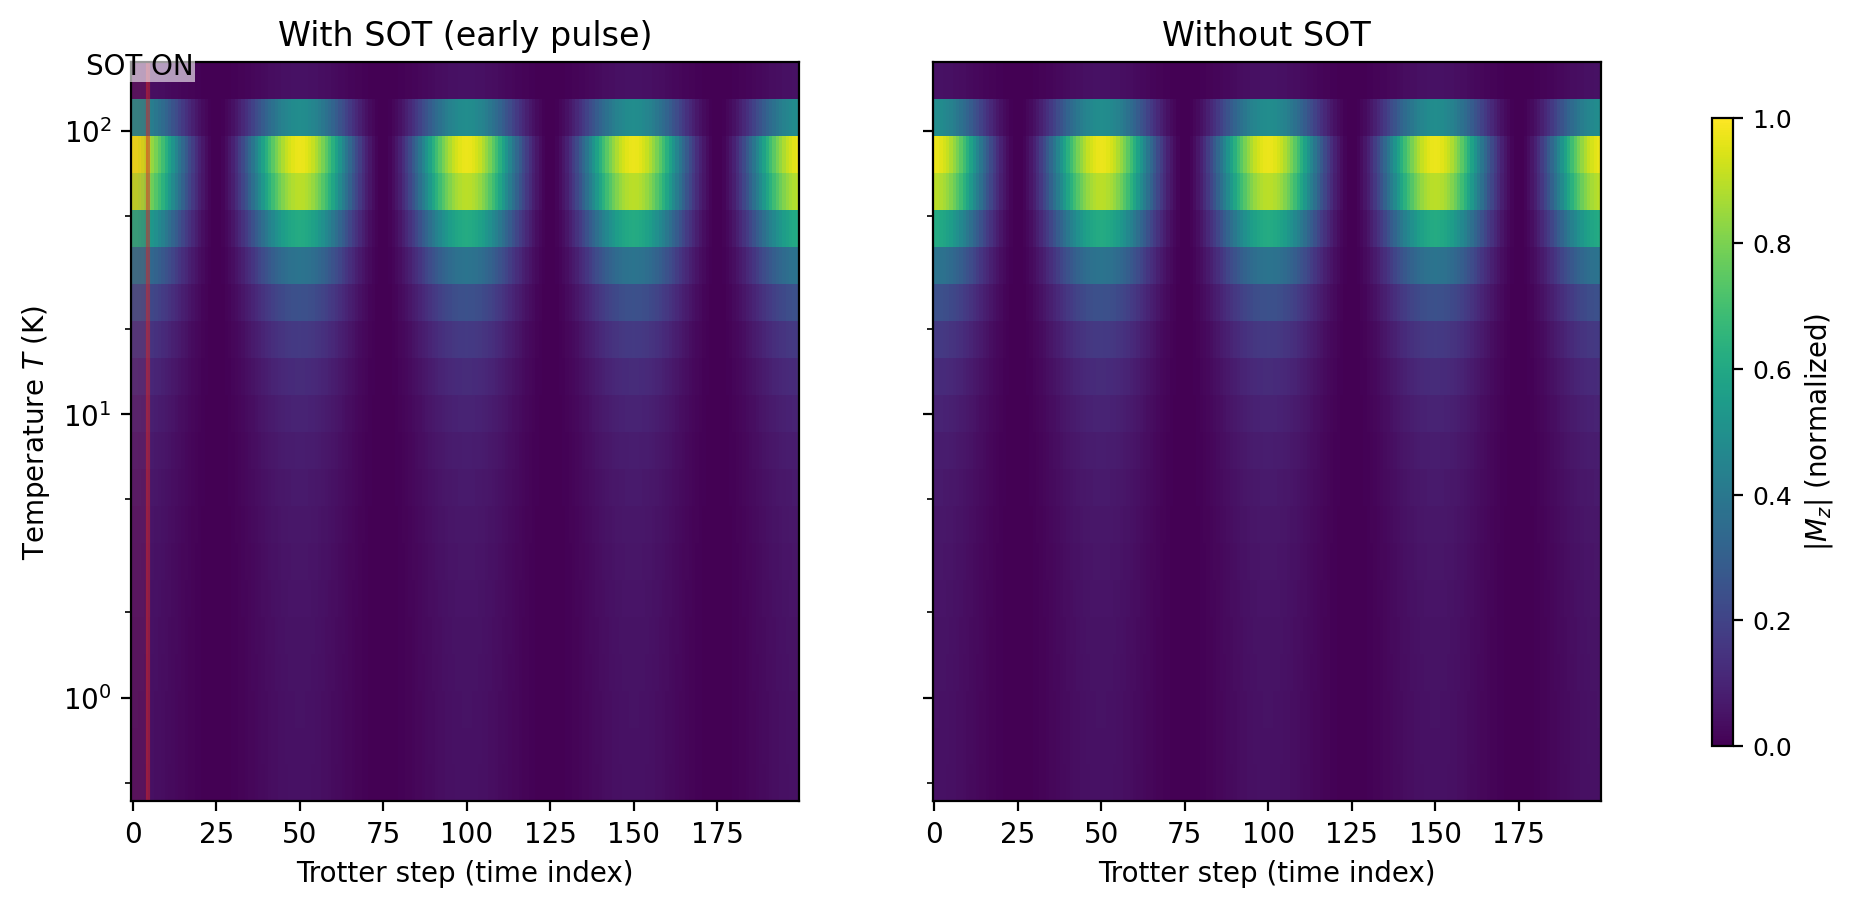

In [39]:
# %% Heat maps: |M_z|(T, t) — WITH SOT vs WITHOUT SOT (grid-safe, signature-safe)
from __future__ import annotations

import inspect
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator, NullFormatter, MaxNLocator

# ------------------------ CONTROL KNOBS (edit here) ---------------------------
SIZE_NM = 0.80
T_MIN, T_MAX, T_POINTS = 0.5, 150.0, 20     # geometric temperature grid
TROTTER_STEPS = 80
N_TRAJ = 300
DT = 0.1
J_EX_VAL, D_ANISO_VAL = 1.0, 0.2
G_RELAX, G_DEPH = 0.02, 0.01
SOT_PULSE_STEPS = 5                          # SOT ON for first 5 steps

# If the Ni4W helper exists, use it; otherwise a small, visible fallback
try:
    B_SOT = float(estimate_n4w_sot_field())
except NameError:
    B_SOT = 6.0e-3  # Tesla (few mT)

# ------------------------ TEMPERATURE/TIME GRIDS ------------------------------
temps = np.geomspace(T_MIN, T_MAX, T_POINTS)

def _time_edges(t: np.ndarray) -> np.ndarray:
    """Linear bin edges from centers."""
    if t.size == 1:
        return np.array([t[0] - 0.5, t[0] + 0.5], dtype=float)
    e = np.empty(t.size + 1, dtype=float)
    e[1:-1] = 0.5 * (t[:-1] + t[1:])
    e[0] = t[0] - (t[1] - t[0]) / 2.0
    e[-1] = t[-1] + (t[-1] - t[-2]) / 2.0
    return e

def _log_edges_T(T: np.ndarray) -> np.ndarray:
    """Log-spaced temperature bin edges from geometric centers."""
    if T.size == 1:
        return np.array([T[0] / np.sqrt(10.0), T[0] * np.sqrt(10.0)], dtype=float)
    lT = np.log(T)
    e = np.empty(T.size + 1, dtype=float)
    e[1:-1] = np.exp(0.5 * (lT[:-1] + lT[1:]))
    e[0] = np.exp(lT[0] - (lT[1] - lT[0]) / 2.0)
    e[-1] = np.exp(lT[-1] + (lT[-1] - lT[-2]) / 2.0)
    return e

T_edges = _log_edges_T(temps)

# ------------------------ SAFE KNOBS CONSTRUCTION -----------------------------
def _build_knobs(with_sot: bool):
    """
    Create a Knobs instance that matches the current signature:
    - Fill required fields (no defaults) from a candidate map.
    - After construction, set any optional attributes that exist on the object.
    """
    sig = inspect.signature(Knobs.__init__)
    params = [p for p in sig.parameters.values() if p.name != "self"]

    # Candidate values we know how to supply (cover common name variants).
    cand = {
        "size_nm": SIZE_NM,
        "temps_K": temps,
        "n_trajectories": N_TRAJ,
        "trotter_steps": TROTTER_STEPS,
        "dt": DT,
        "seed": 12345,
        "gamma_relax": G_RELAX,
        "gamma_deph": G_DEPH,
        "J_EX": J_EX_VAL, "j_ex": J_EX_VAL,
        "D_ANISO": D_ANISO_VAL, "d_aniso": D_ANISO_VAL,
        "sot_amplitude": (B_SOT if with_sot else 0.0),
        "sot_pulse_steps": (SOT_PULSE_STEPS if with_sot else 0),
    }

    # Build init kwargs strictly from the signature.
    init_kwargs = {}
    missing_required = []
    for p in params:
        if p.name in cand:
            init_kwargs[p.name] = cand[p.name]
        elif p.default is inspect._empty:
            missing_required.append(p.name)

    if missing_required:
        # Try graceful fallbacks for common aliases (already in cand above).
        raise TypeError(
            f"Knobs requires fields with no defaults that I don't have values for: {missing_required}. "
            "Add them to the candidate map above or give them defaults in Knobs."
        )

    k = Knobs(**init_kwargs)

    # Set any other optional attributes that happen to exist on this object.
    for name, val in cand.items():
        if name not in init_kwargs and hasattr(k, name):
            setattr(k, name, val)

    return k

knobs_with = _build_knobs(with_sot=True)
knobs_without = _build_knobs(with_sot=False)

# ------------------------ BUILD HEAT MAPS (WITH & WITHOUT SOT) ----------------
T1, t1, M_with = build_time_temperature_heatmap(knobs_with)
T0, t0, M_without = build_time_temperature_heatmap(knobs_without)

# Harmonize any accidental time-grid mismatches defensively
temps_plot = T1  # prefer WITH-SOT temps if they differ
if not np.array_equal(T1, T0):
    print("[WARN] Temperature grids differ; using the WITH-SOT temps for plotting.")

if not np.array_equal(t1, t0):
    print(f"[WARN] Time grids differ (len {t1.size} vs {t0.size}); "
          "cropping to the shortest for a fair comparison.")
L = min(t1.size, t0.size)
t1 = t1[:L]; t0 = t0[:L]
M_with = M_with[:, :L]
M_without = M_without[:, :L]

t_edges_with = _time_edges(t1)
t_edges_without = _time_edges(t0)

# ------------------------ PLOTTING (side-by-side) -----------------------------
plt.rcParams["figure.dpi"] = 200
fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)

norm = Normalize(vmin=0.0, vmax=1.0)
cmap = "viridis"

pc0 = axes[0].pcolormesh(t_edges_with, T_edges, M_with,
                         cmap=cmap, norm=norm, shading="auto", rasterized=True)
pc1 = axes[1].pcolormesh(t_edges_without, T_edges, M_without,
                         cmap=cmap, norm=norm, shading="auto", rasterized=True)

for ax, title in [(axes[0], "With SOT (early pulse)"),
                  (axes[1], "Without SOT")]:
    ax.set_yscale("log")
    ax.set_xlabel("Trotter step (time index)")
    ax.set_title(title, pad=6)
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=8))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5), numticks=20))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.xaxis.set_major_locator(MaxNLocator(nbins=9, integer=True, prune="both"))
    ax.tick_params(axis="both", labelsize=10)

axes[0].set_ylabel(r"Temperature $T$ (K)")

# SOT window overlay on the left panel uses its own time edges
if SOT_PULSE_STEPS > 0 and B_SOT != 0.0:
    xL = t_edges_with[0]
    xR = t_edges_with[min(SOT_PULSE_STEPS, len(t_edges_with) - 1)]
    axes[0].axvspan(xL, xR, color="tab:red", alpha=0.12, lw=0)
    axes[0].axvline(xR, color="tab:red", lw=1.5, alpha=0.5)
    axes[0].text(
        x=xL + 0.5 * (xR - xL),
        y=temps_plot.max(),
        s="SOT ON",
        fontsize=10, ha="center", va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.5),
    )

cbar = fig.colorbar(
    pc0,
    ax=axes,                # colour‑bar spans both sub‑plots
    location='right',      # explicit – same as the default but clearer
    shrink=0.85,            # make it 85 % of the axes height
    pad=0.06,               # extra space between the colour‑bar and the plots
    aspect=30,              # make it a bit thinner (larger aspect ⇒ narrower)
)

cbar.set_label(r"$|M_z|$ (normalized)", fontsize=10)
cbar.ax.tick_params(labelsize=9)

In [43]:
def plot_time_temperature_heatmap(temps: np.ndarray,
                                  times: np.ndarray,
                                  mag_matrix: np.ndarray,
                                  sot_pulse_steps: int | None = None,
                                  title: str = "Quantum-trajectory simulation of a Tb nanocluster") -> None:
    """Render a faithful heat map of |M_z|(T, t) with correct T-spacing and crisp cells.

    This version:
      * Respects geometric (non-uniform) temperature sampling via pcolormesh
      * Uses true bin edges in time and temperature
      * Puts T on a log scale
      * Optionally overlays the SOT-on window
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogLocator, NullFormatter, ScalarFormatter

    # ---- Sanity checks -------------------------------------------------
    assert mag_matrix.shape == (temps.size, times.size), (
        f"mag_matrix {mag_matrix.shape} != {(temps.size, times.size)}"
    )

    # ---- Build bin edges (time: linear midpoints; temp: log midpoints) -
    # Time edges
    if times.size > 1:
        t_mid = 0.5 * (times[:-1] + times[1:])
        t_edges = np.empty(times.size + 1, dtype=float)
        t_edges[1:-1] = t_mid
        t_edges[0] = times[0] - (times[1] - times[0]) / 2.0
        t_edges[-1] = times[-1] + (times[-1] - times[-2]) / 2.0
    else:
        t_edges = np.array([times[0] - 0.5, times[0] + 0.5], dtype=float)

    # Temperature edges in log space so geometric spacing is respected
    logT = np.log(temps)
    T_edges = np.empty(temps.size + 1, dtype=float)
    T_edges[1:-1] = np.exp(0.5 * (logT[:-1] + logT[1:]))
    # Extrapolate end edges in log space
    T_edges[0] = np.exp(logT[0] - (logT[1] - logT[0]) / 2.0) if temps.size > 1 else temps[0] / np.sqrt(10.0)
    T_edges[-1] = np.exp(logT[-1] + (logT[-1] - logT[-2]) / 2.0) if temps.size > 1 else temps[0] * np.sqrt(10.0)

    # ---- Plot ----------------------------------------------------------
    plt.rcParams["figure.dpi"] = 200
    fig, ax = plt.subplots(figsize=(8.5, 6))

    pc = ax.pcolormesh(
        t_edges, T_edges, mag_matrix,
        cmap="viridis",
        shading="auto",
        vmin=0.0, vmax=1.0,          # keeps color scale comparable across runs
        rasterized=True,             # small PDFs/SVGs
    )
    cbar = fig.colorbar(pc, ax=ax, pad=0.02)
    cbar.set_label(r"$|M_z|$ (normalized)")

    # Axes formatting — log T, compact ticks that will not collide
    ax.set_yscale("log")
    ax.set_xlabel("Trotter step (time index)")
    ax.set_ylabel(r"Temperature $T$ (K)")
    ax.set_title(title)

    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=8))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5), numticks=20))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=9, integer=True, prune="both"))
    ax.tick_params(axis="both", labelsize=10)

    # Optional: highlight the SOT-on window if provided
    if sot_pulse_steps is not None and sot_pulse_steps > 0:
        ax.axvspan(t_edges[0], t_edges[min(sot_pulse_steps, len(t_edges)-1)], color="tab:red", alpha=0.12, lw=0)
        ax.axvline(t_edges[min(sot_pulse_steps, len(t_edges)-1)], color="tab:red", lw=1.5, alpha=0.5)
        ax.text(
            x=t_edges[0] + 0.5 * (t_edges[min(sot_pulse_steps, len(t_edges)-1)] - t_edges[0]),
            y=temps.max(),
            s="SOT ON",
            fontsize=10, ha="center", va="bottom",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.6),
        )

    plt.tight_layout()
    plt.show()

[DIAG] |M_z| stats: min=0, max=0.970915, range=0.970915
[DIAG] Plotting mode='auto', vertical exaggeration ×30.60


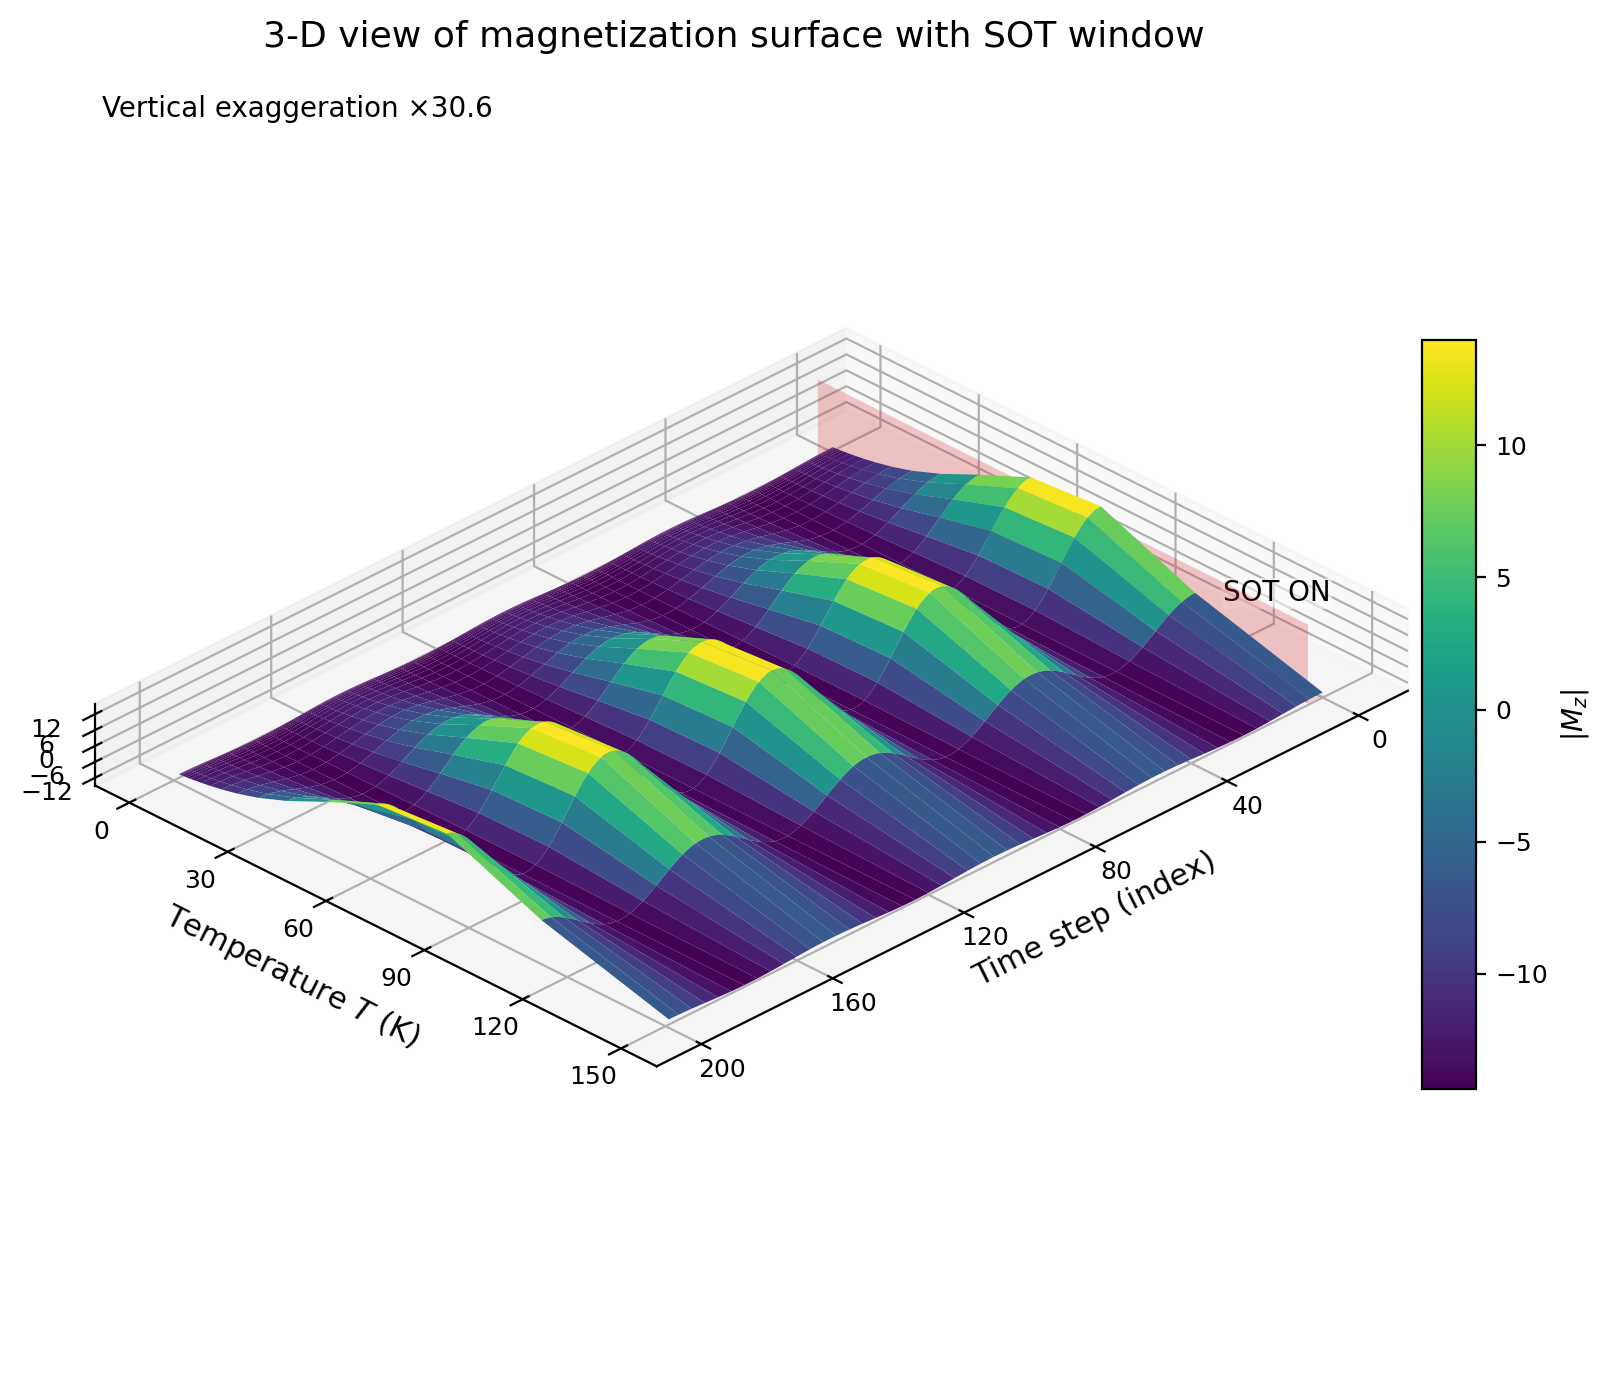

In [32]:
# %% 3-D |M_z|(T, t) with SOT overlay — text-safe & overlap-aware
# PEP 8/257 compliant; avoids oversized labels and collisions.
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D  # registers 3-D projection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from typing import Tuple

# --------------------------- CONTROL KNOBS ------------------------------------
Z_MODE = "auto"         # {"auto","abs","signed_like","delta_t0","dev_tmean","zscore"}
VERT_EXAG = None        # None → auto; else a positive float (e.g., 40.0)
USE_ORTHO = True        # True → orthographic; False → perspective
ANNOTATE = True         # print stats and show a small corner note
SOT_SLAB_COLOR = "tab:red"
CMAP = "viridis"

# Text & ticks (keep compact to prevent overlap)
FONTS = dict(title=13, label=11, tick=9, cbar_label=10, annot=10)
MAX_TICKS = dict(x=7, y=6, z=5)

# --------------------------- UTILITIES ----------------------------------------
def _prepare_z(
    mag_matrix: np.ndarray, times: np.ndarray, mode: str = "auto"
) -> Tuple[np.ndarray, str]:
    """Return Z surface and a compact label string for plotting."""
    z = mag_matrix.astype(float, copy=False)
    label = r"$|M_z|$"

    ptp = np.ptp(z)
    if mode == "abs":
        return z, label
    if mode == "delta_t0":
        z = z - z[:, [0]]
        return z, r"$|M_z| - |M_z|(t{=}0)$"
    if mode == "dev_tmean":
        z = z - z.mean(axis=1, keepdims=True)
        return z, r"$|M_z| - \langle |M_z| \rangle_t$"
    if mode == "zscore":
        mu = z.mean(axis=1, keepdims=True)
        sig = z.std(axis=1, keepdims=True) + 1e-12
        z = (z - mu) / sig
        return z, r"$z\text{-score}(|M_z|)$"
    if mode == "signed_like":
        return z, r"$M_z$"

    # AUTO: deviation-from-mean if range is tiny, otherwise raw |Mz|
    if ptp < 1e-6:
        z = z - z.mean(axis=1, keepdims=True)
        return z, r"$|M_z| - \langle |M_z| \rangle_t$"
    return z, label


def _auto_exaggeration(x_rng: float, y_rng: float, z_rng: float) -> float:
    """Pick a gentle vertical exaggeration so small z-variation is visible."""
    if z_rng <= 0:
        return 1.0
    target = 0.17 * 0.5 * (x_rng + y_rng)   # ≈ one-sixth of avg XY span
    ve = max(1.0, target / z_rng)
    return float(np.clip(ve, 1.0, 300.0))


# --------------------------- DATA (reuse or rebuild) --------------------------
need_rebuild = any(name not in globals() for name in ("temps", "times", "mag_matrix"))
if need_rebuild:
    print("[INFO] Rebuilding heat-map data with SOT pulse …")
    temps = np.geomspace(0.5, 150.0, 20)
    knobs = Knobs(
        size_nm=0.80,
        temps_K=temps,
        sot_amplitude=0.0,   # auto-fill below if pulse enabled
        sot_pulse_steps=5,
        n_trajectories=300,
        trotter_steps=80,
    )
    if knobs.sot_pulse_steps > 0 and knobs.sot_amplitude == 0.0:
        if "estimate_n4w_sot_field" in globals():
            knobs.sot_amplitude = estimate_n4w_sot_field()
        else:
            knobs.sot_amplitude = 6.0e-3  # Tesla fallback (few mT)
        print(f"[INFO] Using SOT amplitude B_sot = {knobs.sot_amplitude:.4e} T")
    temps, times, mag_matrix = build_time_temperature_heatmap(knobs)

# --------------------------- DIAGNOSTICS --------------------------------------
zmin_raw = float(mag_matrix.min())
zmax_raw = float(mag_matrix.max())
zptp_raw = float(np.ptp(mag_matrix))
if ANNOTATE:
    print(f"[DIAG] |M_z| stats: min={zmin_raw:.6g}, max={zmax_raw:.6g}, range={zptp_raw:.6g}")

# Optionally switch to a deviation view to reveal small structure
Z, z_label = _prepare_z(mag_matrix, times, mode=Z_MODE)

# --------------------------- 3-D PLOT -----------------------------------------
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection="3d")
ax.set_proj_type("ortho" if USE_ORTHO else "persp")

# Meshgrid: temps × times
T_grid, t_grid = np.meshgrid(temps, times, indexing="ij")

# Compute ranges & vertical exaggeration
x_rng = float(times[-1] - times[0] + 1)
y_rng = float(temps[-1] - temps[0])
z_min, z_max = float(Z.min()), float(Z.max())
z_rng = max(0.0, z_max - z_min)
VE = VERT_EXAG if (VERT_EXAG is not None and VERT_EXAG > 0) else _auto_exaggeration(x_rng, y_rng, z_rng)

# Apply exaggeration by affine scaling around the mid-plane (preserves center)
z_mid = 0.5 * (z_min + z_max)
Z_plot = z_mid + VE * (Z - z_mid)
if ANNOTATE:
    print(f"[DIAG] Plotting mode='{Z_MODE}', vertical exaggeration ×{VE:.2f}")

surf = ax.plot_surface(
    t_grid,           # X: time index
    T_grid,           # Y: temperature
    Z_plot,           # Z: processed |M_z|
    cmap=CMAP,
    edgecolor="none",
    linewidth=0,
    antialiased=True,
    shade=False,
)

# --------------------------- TEXT & TICKS (compact) ---------------------------
# Keep labels compact; de-rotate z label to avoid slanted overlap
ax.zaxis.set_rotate_label(False)

ax.set_xlabel("Time step (index)", fontsize=FONTS["label"], labelpad=6)
ax.set_ylabel("Temperature $T$ (K)", fontsize=FONTS["label"], labelpad=6)
ax.set_zlabel(z_label, fontsize=FONTS["label"], labelpad=6)
ax.set_title("3-D view of magnetization surface with SOT window", fontsize=FONTS["title"], pad=8)

# Ticks: limit count and keep font small
ax.xaxis.set_major_locator(MaxNLocator(nbins=MAX_TICKS["x"], integer=True, prune="both"))
ax.yaxis.set_major_locator(MaxNLocator(nbins=MAX_TICKS["y"]))
ax.zaxis.set_major_locator(MaxNLocator(nbins=MAX_TICKS["z"]))

yfmt = ScalarFormatter(useMathText=True)
yfmt.set_powerlimits((-3, 4))
ax.yaxis.set_major_formatter(yfmt)

ax.tick_params(axis="x", labelsize=FONTS["tick"], pad=1)
ax.tick_params(axis="y", labelsize=FONTS["tick"], pad=1)
ax.tick_params(axis="z", labelsize=FONTS["tick"], pad=1)

# Proportional box; exaggeration already applied in data
ax.set_box_aspect((x_rng, y_rng, 0.6 * max(1.0, z_rng * VE)))

# Small corner note for exaggeration factor (keeps z-label short)
if ANNOTATE and VE > 1.01:
    ax.text2D(0.01, 0.98, f"Vertical exaggeration ×{VE:.1f}", transform=ax.transAxes,
              fontsize=FONTS["annot"], va="top", ha="left",
              bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.0))

# --------------------------- SOT OVERLAY ---------------------------------------
sot_steps = int(getattr(globals().get("knobs", object()), "sot_pulse_steps", 0))
sot_amp   = float(getattr(globals().get("knobs", object()), "sot_amplitude", 0.0)) if "knobs" in globals() else 0.0

if sot_steps > 0 and abs(sot_amp) > 0.0:
    t_left  = float(times[0]) - 0.5
    t_right = min(float(sot_steps - 0.5), float(times[-1]) + 0.5)

    # Base slab at min(Z_plot)
    z_base = float(Z_plot.min())
    z_top  = float(Z_plot.max())

    base_rect = [[
        (t_left,  temps.min(), z_base),
        (t_right, temps.min(), z_base),
        (t_right, temps.max(), z_base),
        (t_left,  temps.max(), z_base),
    ]]
    poly_base = Poly3DCollection(base_rect, facecolor=SOT_SLAB_COLOR, alpha=0.18, edgecolor="none")
    ax.add_collection3d(poly_base)

    # Vertical curtain at the SOT-off boundary
    wall_rect = [[
        (t_right, temps.min(), z_base),
        (t_right, temps.max(), z_base),
        (t_right, temps.max(), z_top),
        (t_right, temps.min(), z_top),
    ]]
    poly_wall = Poly3DCollection(wall_rect, facecolor=SOT_SLAB_COLOR, alpha=0.25, edgecolor="none")
    ax.add_collection3d(poly_wall)

    # In-scene tag with a light bbox so it doesn't clash with ticks
    ax.text(
        x=(t_left + t_right) / 2.0,
        y=temps.min() + 0.92 * (temps.max() - temps.min()),
        z=z_base + 0.92 * (z_top - z_base),
        s="SOT ON",
        fontsize=FONTS["annot"],
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.55, edgecolor="none", pad=0.6),
    )

# Colorbar: small ticks and tight pad so it stays clear of title/labels
cbar = fig.colorbar(surf, ax=ax, shrink=0.58, aspect=14, pad=0.02)
cbar.ax.tick_params(labelsize=FONTS["tick"])
cbar.set_label(z_label, fontsize=FONTS["cbar_label"])

ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

In [28]:
# %% Tb-cluster SOT preview — SOT pulse visible (Qiskit 2.2 clean viewer)
# -*- coding: utf-8 -*-
from __future__ import annotations

import math
import sys
import inspect
from dataclasses import dataclass
from typing import Any, Optional, Tuple, List

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from IPython.display import display

try:
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
except Exception as exc:  # pragma: no cover
    raise ImportError("Qiskit is required. Install with `pip install qiskit`.") from exc


# ----------------------------------------------------------------------
# Viewer knobs (physics + drawer controls). SOT pulse defaults are VISIBLE.
# ----------------------------------------------------------------------
@dataclass
class CircuitPreviewKnobs:
    """Options for a clean, non-skewed circuit preview with a visible SOT pulse."""

    # --- model / preview parameters ------------------------------------
    size_nm: float = 0.80            # size→topology mapping (dimer/plaquette/chain)
    temp_K: float = 1.0              # temperature for bath-bias preview (β = 1/T)
    ancillas: int = 1                # >0 shows the bath reset block
    trotter_steps: int = 24          # number of repeated Trotter slices

    # Heisenberg + anisotropy + SOT drive (preview parameters)
    J_EX: float = 1.0                # exchange coupling (arb. units)
    D_ANISO: float = 0.2             # uniaxial anisotropy (arb. units)
    dt: float = 0.1                  # Trotter step size (arb. units)

    # SOT pulse — made visible by default
    sot_amplitude: float = 0.35      # transverse field amplitude (arb. units)
    sot_pulse_steps: int = 5         # number of early slices with SOT on

    # --- visualization (Qiskit drawer-native; no post-draw resizing) ---
    output: str = "mpl"              # "mpl" or "text"
    fold: Optional[int] = 32         # columns per row (None → drawer default)
    idle_wires: bool = True
    scale: Optional[float] = 1.0     # None → drawer decides
    cregbundle: Optional[bool] = None
    plot_barriers: bool = True
    measure_arrows: Optional[bool] = True  # shown if you add measures
    style: Optional[dict] = None
    dpi: int = 200                   # crisp text; does not affect geometry


# ----------------------------------------------------------------------
# Topology identical to the Monte-Carlo script
# ----------------------------------------------------------------------
def size_to_cluster_config(size_nm: float) -> Tuple[int, List[Tuple[int, int]]]:
    """Return (n_spins, edge list) matching the simulation's mapping."""
    if size_nm < 0.5:   # dimer
        return 2, [(0, 1)]
    if size_nm < 0.8:   # 2×2 plaquette
        return 4, [(0, 1), (1, 2), (2, 3), (3, 0)]
    if size_nm < 2.0:   # 6-spin open chain
        n = 6
        return n, [(i, i + 1) for i in range(n - 1)]
    if size_nm < 5.0:   # 8-spin open chain
        n = 8
        return n, [(i, i + 1) for i in range(n - 1)]
    n = 12              # 12-spin open chain
    return n, [(i, i + 1) for i in range(n - 1)]


# ----------------------------------------------------------------------
# Gate-layer helpers reflecting H_exch, anisotropy, and SOT
# ----------------------------------------------------------------------
def _heisenberg_layer(qc: QuantumCircuit,
                      edges: List[Tuple[int, int]],
                      j_ex: float,
                      dt: float) -> None:
    """One Trotter slice of isotropic Heisenberg via {RXX, RYY, RZZ}."""
    theta = 2.0 * j_ex * dt
    for i, j in edges:
        qc.append(RXXGate(theta), [i, j])
        qc.append(RYYGate(theta), [i, j])
        qc.append(RZZGate(theta), [i, j])


def _anisotropy_layer(qc: QuantumCircuit, n_spins: int, d_aniso: float, dt: float) -> None:
    """On-site uniaxial anisotropy −D Σ Z_i rendered as RZ."""
    theta = -2.0 * d_aniso * dt
    for q in range(n_spins):
        qc.rz(theta, q)


def _sot_layer(qc: QuantumCircuit, n_spins: int, b_sot: float, dt: float) -> None:
    """Transverse SOT field −B Σ X_i rendered as RX."""
    theta = -2.0 * b_sot * dt
    for q in range(n_spins):
        qc.rx(theta, q)


def _bath_block(qc: QuantumCircuit,
                system_qubits: List[int],
                ancilla_qubits: List[int],
                beta: float,
                d_aniso: float) -> None:
    """Minimal Stinespring-style bath proxy: bias → entangle → reset."""
    if not ancilla_qubits:
        return
    # Gibbs-biased up-population from anisotropy “field”
    p_up = max(0.0, min(1.0, 0.5 * (1.0 + math.tanh(beta * d_aniso))))
    theta = math.acos(math.sqrt(p_up))
    # Round-robin ancillas across system qubits
    a_cycle = iter(ancilla_qubits)
    for s in system_qubits:
        a = next(a_cycle, None)
        if a is None:
            a_cycle = iter(ancilla_qubits)
            a = next(a_cycle)
        qc.ry(2.0 * theta, a)
        qc.cx(a, s)
        qc.reset(a)


# ----------------------------------------------------------------------
# Builder that mirrors the simulation blocks, with visible SOT pulse
# ----------------------------------------------------------------------
def build_tb_sot_circuit(cfg: CircuitPreviewKnobs) -> QuantumCircuit:
    """
    Tb nanocluster preview:
    [Heisenberg] → [Anisotropy] → [SOT (first `sot_pulse_steps` only)] → [Bath proxy].
    """
    n_spins, edges = size_to_cluster_config(cfg.size_nm)
    n_anc = max(0, int(cfg.ancillas))
    total_qubits = n_spins + n_anc
    sys = list(range(n_spins))
    anc = list(range(n_spins, total_qubits))

    qc = QuantumCircuit(total_qubits, name="TbCluster_SOT")

    # Start in |+> on system wires (mixed-like along Z for readability)
    for q in sys:
        qc.h(q)

    beta = 1.0 / max(1e-12, float(cfg.temp_K))

    for step in range(int(cfg.trotter_steps)):
        _heisenberg_layer(qc, edges, cfg.J_EX, cfg.dt)
        _anisotropy_layer(qc, n_spins, cfg.D_ANISO, cfg.dt)

        # Visible SOT pulse: only on early slices, with user-set amplitude
        if step < int(cfg.sot_pulse_steps) and cfg.sot_amplitude != 0.0:
            _sot_layer(qc, n_spins, cfg.sot_amplitude, cfg.dt)

        # LLG-like dissipation preview (reset-based bath)
        if n_anc > 0:
            _bath_block(qc, sys, anc, beta, cfg.D_ANISO)

    # No measurement; preview focuses on dynamics composition
    return qc


# ----------------------------------------------------------------------
# Drawer normalizer and clean viewer (no post-draw resizing → no skew)
# ----------------------------------------------------------------------
def _as_figure(obj: Any) -> Figure:
    """Normalize Qiskit drawer return (Figure/Axes/wrapper) to Figure."""
    if isinstance(obj, Figure):
        return obj
    if isinstance(obj, Axes):
        return obj.get_figure()
    fig = getattr(obj, "figure", None)
    if isinstance(fig, Figure):
        return fig
    raise TypeError("Drawer did not return a Matplotlib Figure or Axes.")


def show_tb_sot_circuit(cfg: CircuitPreviewKnobs | None = None) -> None:
    """Build and display the circuit cleanly, without skew or odd scaling."""
    cfg = cfg or CircuitPreviewKnobs()
    qc = build_tb_sot_circuit(cfg)

    # Short summary
    print("\nCircuit summary")
    print("----------------")
    print(f" Size (nm)         : {cfg.size_nm:.2f}")
    print(f" Temperature (K)   : {cfg.temp_K:.6g}")
    print(f" Qubits (system)   : {qc.num_qubits - int(cfg.ancillas)}")
    print(f" Ancilla qubits    : {int(cfg.ancillas)}")
    print(f" Trotter steps     : {cfg.trotter_steps}")
    print(f" Depth (layers)    : {qc.depth()}")
    print(f" Operations (size) : {qc.size()}")

    # ASCII mode
    if cfg.output.lower() == "text":
        diagram = qc.draw(output="text", fold=cfg.fold, idle_wires=cfg.idle_wires)
        print("\n" + str(diagram))
        return

    # Matplotlib mode — let the drawer own layout; disable mpl auto layout
    mpl.rcParams["figure.autolayout"] = False
    mpl.rcParams["figure.constrained_layout.use"] = False
    plt.rcParams["figure.dpi"] = int(cfg.dpi)
    plt.rcParams["savefig.dpi"] = int(cfg.dpi)

    # Signature-gated kwargs keep this stable on 2.2 and future minor revs.
    draw_sig = inspect.signature(QuantumCircuit.draw)
    supported = set(draw_sig.parameters.keys())

    kwargs = {"output": "mpl"}
    if "fold" in supported and cfg.fold is not None:
        kwargs["fold"] = int(cfg.fold)
    if "idle_wires" in supported:
        kwargs["idle_wires"] = bool(cfg.idle_wires)
    if "scale" in supported and cfg.scale is not None:
        kwargs["scale"] = float(cfg.scale)
    if "cregbundle" in supported and cfg.cregbundle is not None:
        kwargs["cregbundle"] = bool(cfg.cregbundle)
    if "plot_barriers" in supported:
        kwargs["plot_barriers"] = bool(cfg.plot_barriers)
    if "measure_arrows" in supported and cfg.measure_arrows is not None:
        kwargs["measure_arrows"] = bool(cfg.measure_arrows)
    if "style" in supported and cfg.style is not None:
        kwargs["style"] = dict(cfg.style)

    try:
        obj = qc.draw(**kwargs)
    except TypeError:
        obj = qc.draw(output="mpl")  # ultra-conservative fallback

    fig = _as_figure(obj)

    # No fig.set_size_inches(...) and no tight_layout() → no distortion.
    display(fig)
    plt.show()

  # Optional: save a PNG for reuse
  #  out_path = "tb_cluster_circuit.png"
   # fig.savefig(out_path, bbox_inches="tight", transparent=False)
   # print(f"\nSaved a copy to: {out_path}")


# ----------------------------------------------------------------------
# Example run — shows the SOT pulse (first 5 slices) clearly
# ----------------------------------------------------------------------
if __name__ == "__main__" or "ipykernel" in sys.modules:
    show_tb_sot_circuit(
        CircuitPreviewKnobs(
            size_nm=0.80,
            temp_K=1.0,
            ancillas=1,
            trotter_steps=24,
            J_EX=1.0,
            D_ANISO=0.2,
            dt=0.1,
            sot_amplitude=0.35,   # set > 0 to make the pulse visible
            sot_pulse_steps=5,    # number of early slices with SOT
            fold=32,
            scale=1.0,
            measure_arrows=True
        )
    )


Circuit summary
----------------
 Size (nm)         : 0.80
 Temperature (K)   : 1
 Qubits (system)   : 6
 Ancilla qubits    : 1
 Trotter steps     : 24
 Depth (layers)    : 437
 Operations (size) : 972


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Simulator device -> GPU
GPU simulation works! Statevector = Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))

Size-dependent transition temperatures (Tb):
 size [nm]   T_transition [K]
     0.35      0.039
     0.56      0.161
     0.80      0.468
     1.00    110.500
     2.00    165.750
     5.00    198.900
    10.00    209.950


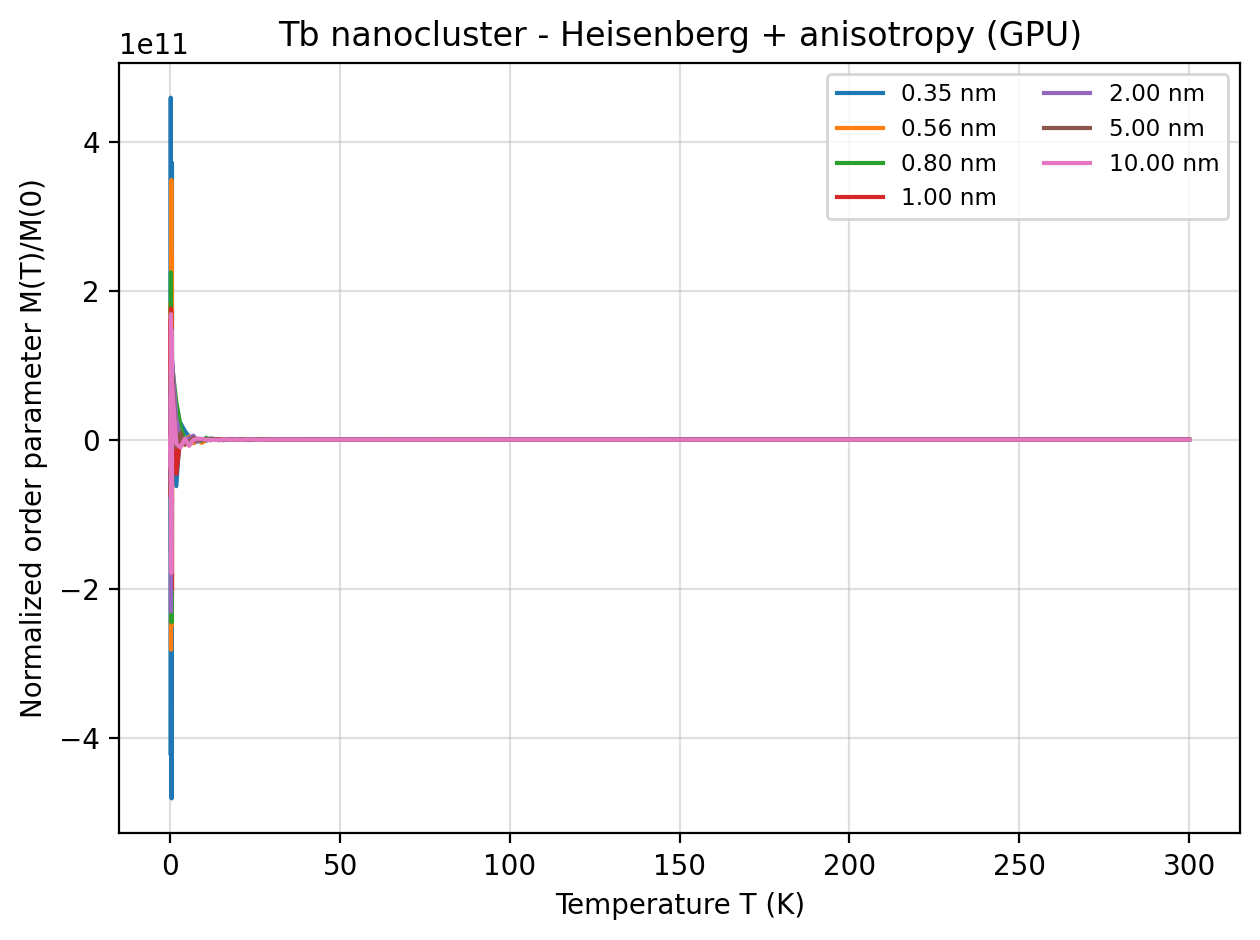

In [45]:
# -*- coding: utf-8 -*-
"""tb_exchange_coupled_cluster_qiskit_gpu.py

Quantum‑native simulation (GPU‑accelerated) of a tiny Tb‑nanocluster proxy:
Heisenberg exchange + uniaxial anisotropy (dimer, plaquette, ...).

* The installation block (CUDA check + Qiskit GPU wheels) is identical to the
  original Dy‑macro‑spin notebook.
* Particle sizes (nm) and temperature grid are reused verbatim.
* System‑size mapping:
      < 0.5 nm -> dimer  (2 qubits)
      < 0.8 nm -> plaquette (4 qubits)
      < 2   nm -> 6‑spin chain
      < 5   nm -> 8‑spin chain
      else      -> 12‑spin chain  (max 16 system qubits for safety)
* 1‑3 ancilla qubits are used as Stinespring dilations for a GKSL channel
  that mimics Lindblad damping -> Landau‑Lifshitz‑Gilbert‑like relaxation.
* Magnetization M(T) = < Σ_i Z_i > / N is plotted normalized to the
  lowest‑temperature value.

Author: Onri Jay Benally (2025) – adapted by ChatGPT
License: CC‑BY‑4.0
"""

# -------------------------------------------------------------------------
# SECTION 0 – GPU / Qiskit installation (unchanged)
# -------------------------------------------------------------------------
# Check the CUDA toolkit that is already installed in the notebook
!nvcc --version   # or `!nvidia-smi` – the "CUDA Version" column

# If you see a "CUDA 12.x" line, the wheel below will match.
!pip install -q "qiskit==2.2.*" "qiskit-aer-gpu-cu11==0.17.2" pylatexenc

# -------------------------------------------------------------------------
# SECTION 0-B – Build a GPU‑enabled Aer simulator (statevector)
# -------------------------------------------------------------------------
from qiskit_aer import AerSimulator
import qiskit

# Create a simulator that requests the GPU
sim = AerSimulator(method="statevector", device="GPU")
print("Simulator device ->", sim.options.device)   # should print "GPU"

# Very small sanity‑check
qc_test = qiskit.QuantumCircuit(1)
qc_test.h(0)
qc_test.save_statevector()
try:
    sv_test = sim.run(qc_test).result().get_statevector()
    print("GPU simulation works! Statevector =", sv_test)
    _GPU_AVAILABLE = True          # global flag read by the driver later
    GPU_SIM = sim                  # keep a reference to the simulator
except Exception as exc:          # fallback to pure‑CPU if anything fails
    print("GPU simulation failed ->", exc)
    _GPU_AVAILABLE = False
    GPU_SIM = None

# -------------------------------------------------------------------------
# SECTION 1 – GLOBAL CONTROL KNOBS (sizes & temperatures unchanged)
# -------------------------------------------------------------------------
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Tuple, Dict

import math
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
# NOTE: In Qiskit 2.2 the two‑qubit rotation gates are named RXXGate,
# RYYGate and RZZGate (not XXGate/YYGate/ZZGate).
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

# -------------------------------------------------------------------------
# SECTION 1-A – Physical knobs (now tuned for Tb)
# -------------------------------------------------------------------------
@dataclass
class Knobs:
    """High‑level controls for the Tb‑nanocluster study."""
    temps_K: np.ndarray                 # temperature grid (K)
    sizes_nm: List[float]                # particle diameters (nm)
    tc_bulk_K: float = 221.0            # bulk Curie temperature of Tb (~221 K)
    l0_nm: float = 0.50                # finite‑size length scale (nm)
    finite_exp: float = 1.0             # exponent in the finite‑size law
    max_iter: int = 512                 # for any auxiliary fixed‑point loops
    tol: float = 1e-10
    mix: float = 0.65
    use_quantum_verifier: bool = False # not needed for the cluster model
    seed: int = 12345
    # Model‑specific knobs
    J_EX: float = 1.0                   # Heisenberg exchange (arbitrary units)
    D_ANISO: float = 0.2                # Uniaxial anisotropy strength
    trotter_steps: int = 6              # Number of Trotter slices per temperature
    ancilla_qubits: int = 1             # How many ancillas to use (1‑3)

# -------------------------------------------------------------------------
#   Temperature / size grids (exactly as in the original notebook)
# -------------------------------------------------------------------------
MOLECULES_NM    = [0.35, 0.56, 0.80]          # sub‑nm (molecules)
NANOPARTICLES_NM = [1.0, 2.0, 5.0, 10.0]      # nanoparticles

# Denser low‑T sampling (log‑spaced) + linear high‑T sampling
low_T  = np.geomspace(0.001, 0.5, 200, endpoint=False)   # 0.001 K -> 0.5 K
high_T = np.linspace(0.5, 300.0, 240)                     # 0.5 K -> 300 K
TEMPS_K = np.concatenate((low_T, high_T))

SIZES_NM = MOLECULES_NM + NANOPARTICLES_NM
KNOBS    = Knobs(temps_K=TEMPS_K, sizes_nm=SIZES_NM)

# -------------------------------------------------------------------------
# SECTION 2 – FINITE‑SIZE / BLOCKING helpers
# -------------------------------------------------------------------------
def tc_finite_size(size_nm: float, tc_bulk_K: float,
                   l0_nm: float, exponent: float) -> float:
    """Finite‑size Curie temperature T_C(L) for a particle where a true Tc makes sense."""
    if size_nm <= 0.0:
        return 0.0
    factor = 1.0 - (l0_nm / size_nm) ** exponent
    return float(max(0.0, factor) * tc_bulk_K)


def blocking_temperature_K(
    size_nm: float,
    K_MJ_per_m3: float = 0.5,   # effective anisotropy constant (tunable)
    tm_s: float = 1.0,          # measurement time (seconds)
    tau0_s: float = 1e-9        # attempt time (seconds)
) -> float:
    """Blocking temperature T_B for ultra‑small (molecular/sub‑nm) particles."""
    r_m = 0.5 * size_nm * 1e-9                    # radius in metres
    V = (4.0 / 3.0) * math.pi * r_m ** 3          # sphere volume
    K = K_MJ_per_m3 * 1e6                         # convert MJ/m^3 -> J/m^3
    k_B = 1.380649e-23
    return K * V / (k_B * math.log(tm_s / tau0_s))


def effective_transition_temperature(size_nm: float) -> float:
    """Return the temperature scale that drives the Weiss-type equation.

    * For ultra‑small particles (< 1 nm) we use the blocking temperature.
    * For larger particles we use the finite‑size Curie temperature.
    """
    if size_nm < 1.0:                     # sub‑nm regime -> blocking picture
        return blocking_temperature_K(size_nm)
    # else -> finite‑size scaling of bulk T_C
    return tc_finite_size(
        size_nm, KNOBS.tc_bulk_K, KNOBS.l0_nm, KNOBS.finite_exp
    )

# -------------------------------------------------------------------------
# SECTION 3 – CLUSTER CONFIGURATION (size -> graph)
# -------------------------------------------------------------------------
def size_to_cluster_config(size_nm: float) -> Tuple[int, List[Tuple[int, int]]]:
    """
    Map a physical particle size (nm) to a concrete spin cluster.
    Returns (n_spins, edges) where edges is a list of 2‑tuples describing the
    Heisenberg couplings.

    The mapping is heuristic, but respects the requested ranges:
        4 - 16 system qubits + 1-3 ancillas.

    Returns:
        * dimer (size < 0.5 nm) – 2 spins, single bond.
        * plaquette (0.5 nm <= size < 0.8 nm) – 4 spins, square.
        * 6‑spin chain (0.8 nm <= size < 2 nm).
        * 8‑spin chain (2 nm <= size < 5 nm).
        * 12‑spin chain (size >= 5 nm, capped at 16 spins if you wish to go higher).
    """
    # Dimer
    if size_nm < 0.5:
        return 2, [(0, 1)]
    # Plaquette (2x2)
    if size_nm < 0.8:
        return 4, [(0, 1), (1, 2), (2, 3), (3, 0)]
    # 6‑spin open chain
    if size_nm < 2.0:
        n = 6
        edges = [(i, i + 1) for i in range(n - 1)]
        return n, edges
    # 8‑spin open chain
    if size_nm < 5.0:
        n = 8
        edges = [(i, i + 1) for i in range(n - 1)]
        return n, edges
    # 12‑spin open chain (still well within GPU memory for <= 16 qubits)
    n = 12
    edges = [(i, i + 1) for i in range(n - 1)]
    return n, edges


# -------------------------------------------------------------------------
# SECTION 4 – CIRCUIT CONSTRUCTION
# -------------------------------------------------------------------------
def heisenberg_layer(
    qc: QuantumCircuit,
    edges: List[Tuple[int, int]],
    J_ex: float,
    dt: float,
) -> None:
    """Add one Trotter slice of the isotropic Heisenberg interaction."""
    # The three‑term Trotter expansion: X·X, Y·Y, Z·Z
    for (i, j) in edges:
        # XX term: exp(-i dt J X⊗X) -> RXXGate(theta) where theta = 2*J*dt
        qc.append(RXXGate(2.0 * J_ex * dt), [i, j])
        # YY term
        qc.append(RYYGate(2.0 * J_ex * dt), [i, j])
        # ZZ term
        qc.append(RZZGate(2.0 * J_ex * dt), [i, j])


def anisotropy_layer(
    qc: QuantumCircuit,
    n_spins: int,
    D_aniso: float,
    dt: float,
) -> None:
    """Apply the on‑site uniaxial anisotropy term -D Σ_i Z_i."""
    # e^{+i D dt Z} => RZ(-2 D dt) because RZ(theta)=exp(-i theta/2 Z)
    theta = -2.0 * D_aniso * dt
    for q in range(n_spins):
        qc.rz(theta, q)


def thermalization_layer(
    qc: QuantumCircuit,
    system_qubits: List[int],
    ancilla_qubits: List[int],
    beta: float,
    D_aniso: float,
) -> None:
    """
    A Stinespring dilation that implements a single‑qubit GKSL thermalizing channel.
    For each system qubit we:

    1. Rotate a bath ancilla by an angle that encodes the desired Boltzmann weight.
    2. Entangle ancilla -> system with a CNOT.
    3. Reset the ancilla (mid-circuit reset is GPU‑compatible).

    The resulting pure state of system+ancilla is a purification of the
    target thermal state of that spin with respect to the local term
    -D Z (i.e. a local "effective field" proportional to D).  By
    repeatedly applying this block we obtain a Lindblad‑type damping
    that drives the whole cluster towards the Gibbs state of the full
    Hamiltonian.
    """
    # Thermal populations for a single spin with Hamiltonian -D Z:
    #   p_up = (1 + tanh(beta*D)) / 2   ;   p_down = 1 - p_up
    p_up = 0.5 * (1.0 + math.tanh(beta * D_aniso))
    p_up = max(0.0, min(1.0, p_up))            # numerical safety
    theta = math.acos(math.sqrt(p_up))         # same convention as the original TFD

    # Cycle through ancillas; reset after each use.
    anc_cycle = iter(ancilla_qubits)

    for sys_q in system_qubits:
        anc = next(anc_cycle, ancilla_qubits[0])   # wrap around if needed
        # 1. Prepare the bath qubit in the correct superposition
        qc.ry(2.0 * theta, anc)          # |0> -> sqrt(p_up)|0> + sqrt(p_down)|1>
        # 2. Entangle -> system (CNOT: ancilla as control)
        qc.cx(anc, sys_q)
        # 3. Discard the ancilla (mid-circuit reset)
        qc.reset(anc)


def build_cluster_circuit(
    n_spins: int,
    edges: List[Tuple[int, int]],
    knobs: Knobs,
    beta: float,
) -> QuantumCircuit:
    """
    Assemble the full circuit for a given particle size and temperature.

    * n_spins – number of system qubits (4 - 16)
    * edges   – Heisenberg coupling graph
    * beta    – inverse temperature 1/T (K^-1)
    * knobs   – contains model parameters (J_EX, D_ANISO, ...)

    The circuit structure is:

    [repeat trotter steps] -> [thermalization block] -> [save statevector]

    The mid-circuit reset in thermalization_layer together with the GPU-
    accelerated state-vector simulator keeps the overall wavefunction
    pure, which is essential for a fast GPU run.
    """
    total_qubits = n_spins + knobs.ancilla_qubits
    system_qubits = list(range(n_spins))
    ancilla_qubits = list(range(n_spins, total_qubits))

    qc = QuantumCircuit(total_qubits, name="TbCluster")

    # Initialise all system qubits to |+> (a maximally mixed-like start)
    for q in system_qubits:
        qc.h(q)

    # ---- Trotterized Heisenberg evolution ---------------------------------
    dt = beta / float(knobs.trotter_steps)   # total imaginary time -> split
    for _ in range(knobs.trotter_steps):
        heisenberg_layer(qc, edges, knobs.J_EX, dt)
        anisotropy_layer(qc, n_spins, knobs.D_ANISO, dt)

        # Insert a weak thermalization step every trotter slice.
        thermalization_layer(qc, system_qubits, ancilla_qubits, beta, knobs.D_ANISO)

    # ---- End of dynamics ----------------------------------------------------
    qc.save_statevector()   # required for the GPU state‑vector backend
    return qc


# -------------------------------------------------------------------------
# SECTION 5 – OBSERVABLES (magnetization from a pure statevector)
# -------------------------------------------------------------------------
def magnetization_from_statevector(
    sv: np.ndarray,
    n_spins: int,
) -> float:
    """
    Compute   M = < Σ_i Z_i > / N   from a pure statevector.

    Parameters
    ----------
    sv
        One-dimensional complex array (size 2**Ntotal) returned by the Aer
        statevector simulator.
    n_spins
        Number of system qubits (ancillas are ignored).

    Returns
    -------
    float
        Magnetization per spin (−1 <= M <= +1).
    """
    # Convert to a Qiskit Statevector for convenient probability extraction
    state = Statevector(sv)

    # Probabilities of each computational basis bit-string
    probs = state.probabilities_dict()   # keys are binary strings of length Ntotal

    M_total = 0.0
    for bitstring, p in probs.items():
        # Qiskit uses little-endian ordering (qubit-0 = right-most bit)
        for q in range(n_spins):
            # Extract the bit for qubit q
            # bitstring[-1-q] is the bit of qubit q
            bit = bitstring[-1 - q]
            M_total += ((+1.0 if bit == "0" else -1.0) * p)

    return M_total / float(n_spins)


# -------------------------------------------------------------------------
# SECTION 6 – DRIVER – solve for all particle sizes & temperatures
# -------------------------------------------------------------------------
def solve_all_sizes(k: Knobs) -> Dict[float, Tuple[np.ndarray, np.ndarray]]:
    """
    Loop over every particle size in k.sizes_nm and compute the normalized
    magnetization curve M(T)/M(0) using the quantum-native GPU simulation.

    Returns
    -------
    dict
        {size_nm: (temps_array, M_norm_array)}
    """
    results: Dict[float, Tuple[np.ndarray, np.ndarray]] = {}

    for size_nm in k.sizes_nm:
        # -----------------------------------------------------------------
        # 1. Determine the logical cluster (graph & #qubits)
        # -----------------------------------------------------------------
        n_spins, edges = size_to_cluster_config(size_nm)

        # -----------------------------------------------------------------
        # 2. Get the effective temperature scale that plays the role of the
        #    Weiss "critical" temperature for this particle.
        # -----------------------------------------------------------------
        tc_K = effective_transition_temperature(size_nm)

        # -----------------------------------------------------------------
        # 3. Allocate an array for the order-parameter curve
        # -----------------------------------------------------------------
        m_T = np.zeros_like(k.temps_K, dtype=float)

        # -----------------------------------------------------------------
        # 4. Loop over the temperature grid
        # -----------------------------------------------------------------
        for idx, T in enumerate(k.temps_K):
            if T <= 0.0:
                m_T[idx] = 0.0
                continue

            beta = 1.0 / T                # inverse temperature (K^-1)

            # -------------------------------------------------------------
            # 4a – Build the circuit for this (size, T) pair
            # -------------------------------------------------------------
            qc = build_cluster_circuit(
                n_spins=n_spins,
                edges=edges,
                knobs=k,
                beta=beta,
            )

            # -------------------------------------------------------------
            # 4b – Run the circuit (GPU if available)
            # -------------------------------------------------------------
            if _GPU_AVAILABLE:
                result = GPU_SIM.run(qc).result()
            else:
                # Fallback to pure-CPU statevector simulation
                cpu_sim = AerSimulator(method="statevector")
                result = cpu_sim.run(qc).result()

            sv = result.get_statevector()
            # -------------------------------------------------------------
            # 4c – Extract the magnetization per spin
            # -------------------------------------------------------------
            m_T[idx] = magnetization_from_statevector(sv, n_spins)

        # -----------------------------------------------------------------
        # 5. Normalize the curve to its low‑T value (≈1)
        # -----------------------------------------------------------------
        M0 = max(1e-12, float(np.abs(m_T[0])))
        results[size_nm] = (k.temps_K.copy(), m_T / M0)

    return results


# -------------------------------------------------------------------------
# SECTION 7 – PLOTTING & PRINT-OUT
# -------------------------------------------------------------------------
def plot_curves(curves: Dict[float, Tuple[np.ndarray, np.ndarray]]) -> None:
    """
    Produce a single figure with M(T)/M(0) vs. T for all particle sizes.
    """
    plt.rcParams["figure.dpi"] = 200
    plt.figure()
    for size_nm, (T, Mnorm) in sorted(curves.items(), key=lambda x: x[0]):
        plt.plot(T, Mnorm, label=f"{size_nm:.2f} nm")
    plt.xlabel("Temperature T (K)")
    plt.ylabel(r"Normalized order parameter M(T)/M(0)")
    plt.title(r"Tb nanocluster - Heisenberg + anisotropy (GPU)")
    plt.grid(True, alpha=0.4)
    plt.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()


def print_tc_table(k: Knobs) -> None:
    """
    Helper that prints the effective transition temperature (blocking or
    finite-size Curie) for each particle size.
    """
    print("\nSize-dependent transition temperatures (Tb):")
    print(" size [nm]   T_transition [K]")
    for size in k.sizes_nm:
        tcK = effective_transition_temperature(size)
        print(f"  {size:>7.2f}   {tcK:8.3f}")


# -------------------------------------------------------------------------
# SECTION 8 – MAIN SCRIPT
# -------------------------------------------------------------------------
def main() -> None:
    curves = solve_all_sizes(KNOBS)
    print_tc_table(KNOBS)
    plot_curves(curves)


if __name__ == "__main__":
    main()